***Проект: телекоммуникации***

  
**Описание проекта: телекоммуникации**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Импорты и чтение данных**

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from numpy.random import RandomState
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier, Pool
from sklearn.svm import LinearSVC
from matplotlib import cm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
! pip install phik
from phik import phik_matrix

In [2]:
contract = pd.read_csv('/datasets/contract_new.csv', index_col=['customerID'],
                          parse_dates=['BeginDate', 'EndDate'])
personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

**Предварительный анализ**

CONTRACT

In [3]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


В дальнейшей обработке у признаков BeginDate, EndDate, MonthlyCharges, TotalCharges изменим типы данных

In [5]:
print('Начало датасета: ', min(contract['BeginDate']))
print('Конец датасета: ', max(contract['BeginDate']))

Начало датасета:  2013-10-01 00:00:00
Конец датасета:  2020-02-01 00:00:00


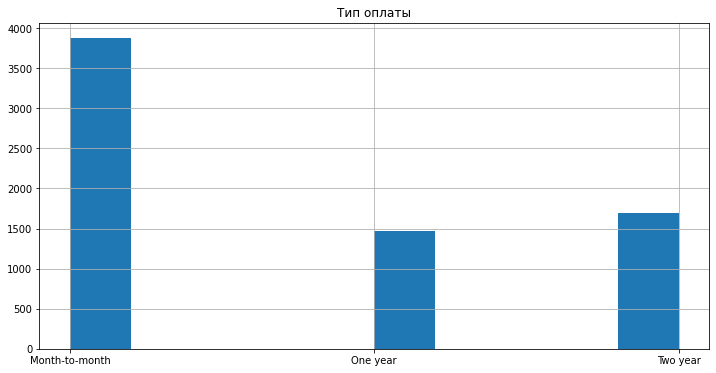

In [6]:
contract['Type'].hist(figsize=(12,6))
plt.title('Тип оплаты');

На графике заметно, что большинство клиентов предпочитают платить ежемесячно. В то же время, можно увидеть, что количество клиентов, оплачивающих за два года сразу, больше, чем тех, кто оплачивает на один год.
Логично предположить, что если платить на длительную перспективу, то условия на 2 года могут быть выгоднее

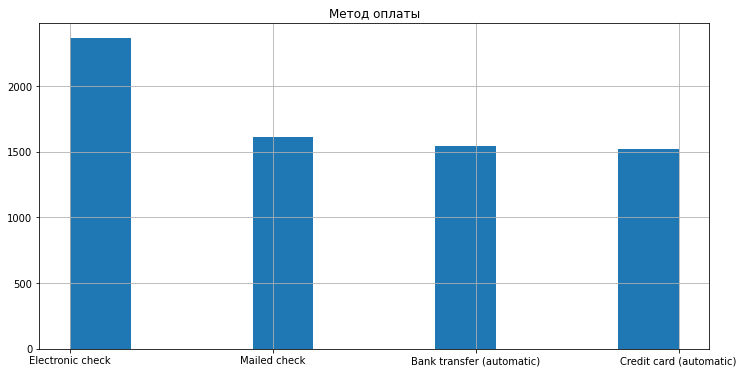

In [7]:
contract['PaymentMethod'].hist(figsize=(12,6))
plt.title('Метод оплаты');

Самый удобный способ оплаты - электронная оплата, что вполне логично

<AxesSubplot:>

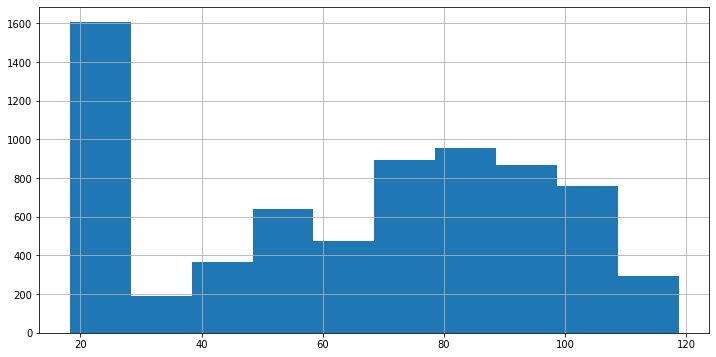

In [8]:
contract['MonthlyCharges'].hist(bins=10, figsize=(12,6))

В дальнейшем изучим выброс значение диапазона 20

PERSONAL

In [9]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [10]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


Text(0.5, 1.0, 'Гендер пользователя')

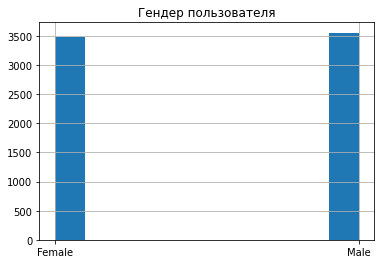

In [11]:
personal['gender'].hist()
plt.title('Гендер пользователя')

Гендеры разделены практически ровно

Text(0.5, 1.0, 'Статус пенсионера')

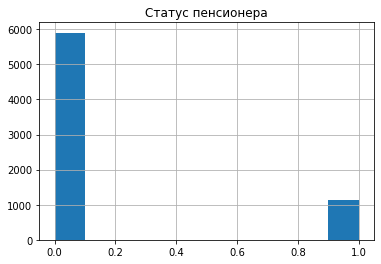

In [12]:
personal['SeniorCitizen'].hist()
plt.title('Статус пенсионера')

Пользователей нового поколения с болшим перевесом больше

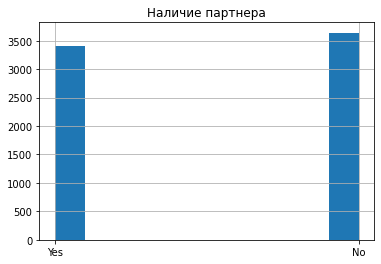

In [13]:
personal['Partner'].hist()
plt.title('Наличие партнера');

Пользователей без партера незначительно больше

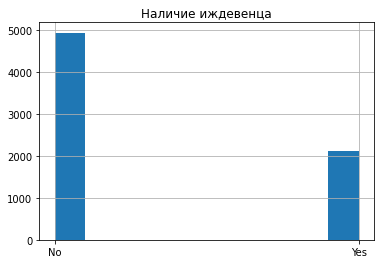

In [14]:
personal['Dependents'].hist()
plt.title('Наличие иждевенца');

Значительный перевес в пользу пользователей без иждевенца

INTERNET

In [15]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


В датасете internet можно заметить не всех пользователей, что абсолютно логично

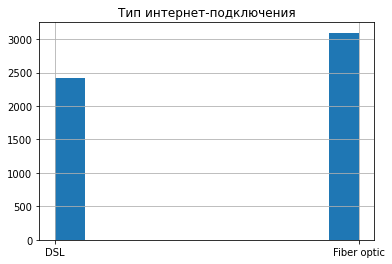

In [17]:
internet['InternetService'].hist()
plt.title('Тип интернет-подключения');

Популярнее среди пользователей оптоволокно

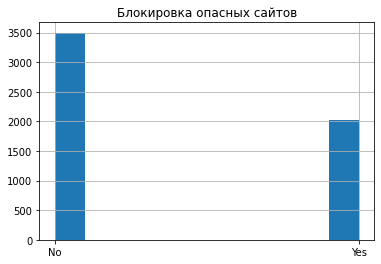

In [18]:
internet['OnlineSecurity'].hist()
plt.title('Блокировка опасных сайтов');

Услугу антивируса популярной назвать нельзя

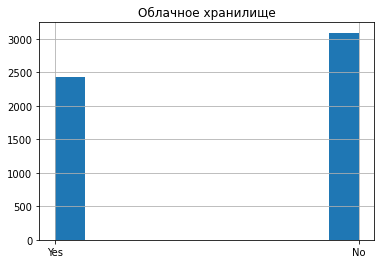

In [19]:
internet['OnlineBackup'].hist()
plt.title('Облачное хранилище');

Облачным хранилищем пользуется меньшая часть пользователей

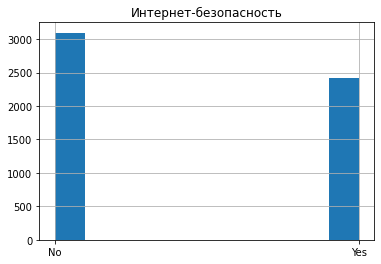

In [20]:
internet['DeviceProtection'].hist()
plt.title('Интернет-безопасность');

Как и с антивирусом, безпасное интернет подключение не является популярной услугой

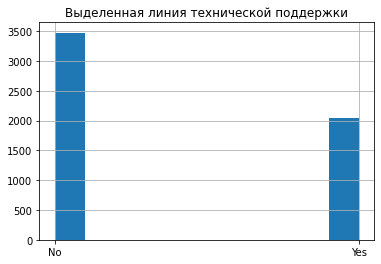

In [21]:
internet['TechSupport'].hist()
plt.title('Выделенная линия технической поддержки');

Доп услуги по "безопасности" не сильно популярный среди пользователей

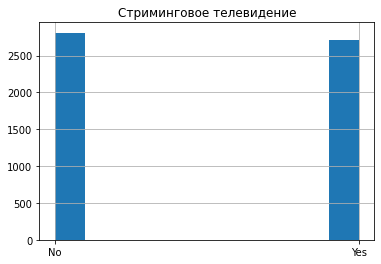

In [22]:
internet['StreamingTV'].hist()
plt.title('Стриминговое телевидение');

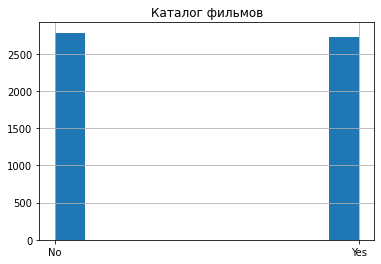

In [23]:
internet['StreamingMovies'].hist()
plt.title('Каталог фильмов');

Доп услуги стримингового сервиса и кинотеки распределены между пользователями практически ровно

PHONE

In [24]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [25]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Также в датасете имеются не все пользователи выборки, что логично, кто-то пользуется только телефонией, кто-то только интернетом

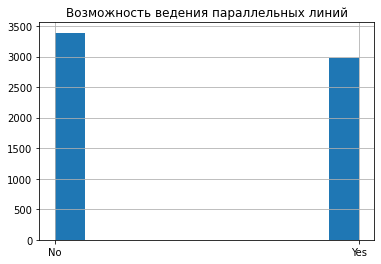

In [26]:
phone['MultipleLines'].hist()
plt.title('Возможность ведения параллельных линий');

Пользователей, отказавшихся в данной услуге, незначительно больше

**Предобработка данных**

Добавляем целевой признак - обозначения разрыва контрака пользователя с компанией

In [27]:
contract['Terminate'] = (contract['EndDate'] != 'No').astype(int)
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Terminate
customerID,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


Перобразуем тип данных у признаков BeginDate, EndDate, MonthlyCharges, TotalCharges

In [28]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

contract['MonthlyCharges'] = contract['MonthlyCharges'].astype(float)

В EndDate дополнительно изменим No на дату конца выборки

In [29]:
contract['EndDate'] = contract['EndDate'].where(contract['EndDate'] != 'No', '2020-02-01')

contract['EndDate'] = pd.to_datetime(contract['EndDate'])


Заполним пропуски в TotalCharges

In [30]:
contract.query('TotalCharges ==  " "')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Terminate
customerID,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0


In [31]:
contract.loc[contract['TotalCharges'] == " ", 'TotalCharges'] = 0


Обнаружены данные неявные пропуски были во время попытки изменения типа данных в столбце, после изменения типа, в столбце образовались пропуски. При просмотре всех неявных пропусков данного столбца (код выше) становится очевидно, что данных нет из-за того, что клиенты оформили договоры с компанией в день сбора данных - они еще не успели ничего приобрести, поэтому было принято решение заполнить пропуски нулями


In [32]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [33]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Terminate         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 495.2+ KB


Приведем все названия признаков к змеиному регистру

In [34]:
contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in contract.columns] 
contract = contract.rename(columns={'customerID':'customer_id'})

personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in personal.columns] 
personal = personal.rename(columns={'customerID':'customer_id'})

internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in internet.columns] 
internet = internet.rename(columns={'customerID':'customer_id'})

phone.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in phone.columns] 
phone = phone.rename(columns={'customerID':'customer_id'})

**Обьединение данных**

In [35]:
data = contract.copy()

Также добавляем признак "длительности" контракта 

In [36]:
data['duration'] = (data['end_date'] - data['begin_date']).dt.days

In [37]:
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,terminate,duration
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


Готовим датасеты для присоединения, поэтому у двух основных услуг добавляем по признаку

In [38]:
internet['internet'] = 1
phone['phone'] = 1

Обьединяем 

In [39]:
data = data.join(personal)
data = data.join(internet)
data = data.join(phone)

Заполняем пропуски 

In [40]:
data = data.fillna('No')

Проверяем пропуски в получившемся датасете

In [41]:
data.isna().mean()

begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
terminate            0.0
duration             0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_t_v        0.0
streaming_movies     0.0
internet             0.0
multiple_lines       0.0
phone                0.0
dtype: float64

**Анализ обьединенного датасета**

Проверяем баланс классов ключевого признака

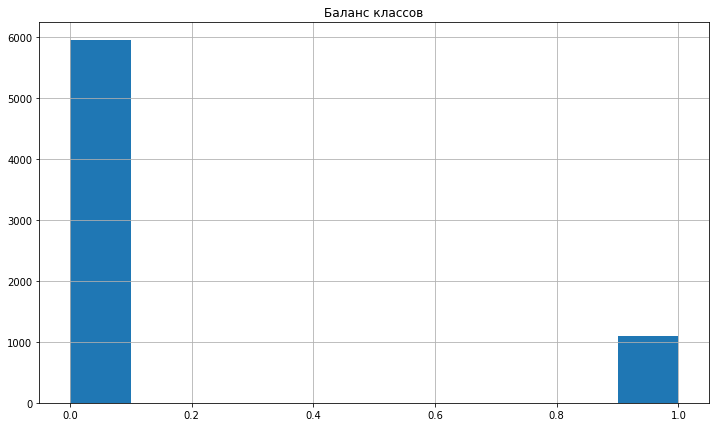

In [42]:
data['terminate'].hist(figsize=(12,7))
plt.title('Баланс классов');

Существенный перевес в сторону пользователей, которе не разорвали контрак с компанией

Анализируем подробно ежемесячные платежи

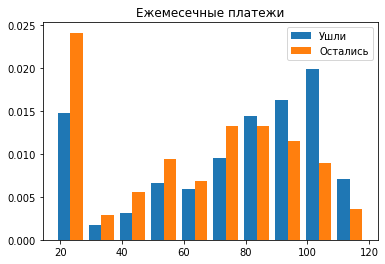

In [43]:
plt.hist([data[data.terminate == 1].monthly_charges, data[data.terminate == 0].monthly_charges], label=['Ушли', 'Остались'], density=True);
plt.legend();
plt.title('Ежемесечные платежи');
plt.show();

Видно, что больше "дорогих" ушедших клиентов, чем "дешевых"

Распределение интернета и телефонии

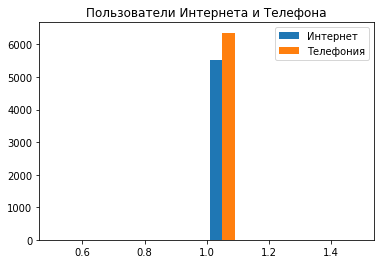

In [44]:
plt.hist([data[data.internet == 1].internet, data[data.phone == 1].phone], label=['Интернет', 'Телефония']);
plt.legend();
plt.title('Пользователи Интернета и Телефона');
plt.show();

Телефония немного популярнее услуги интернет, что логично, ведь компания оператор, который также предоставляет услуги интернет провайдера, а не наоборот

Распределение платежей

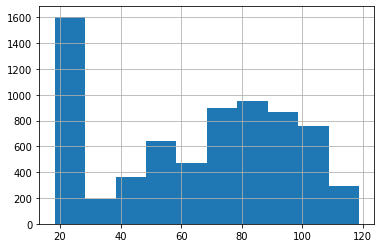

In [45]:
data['monthly_charges'].hist()
plt.show()

Большая концентрация пользователей, которые платят меньше 30

Рассмотрим распределение оказания услуг среди данного выброса пользователей

In [46]:
low_charges = data.query('monthly_charges < 30')

In [47]:
low_charges.sample(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,terminate,duration,gender,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,internet,multiple_lines,phone
customerID,,,,,,,,,,,,,,,,,,,,,
6791-YBNAK,2018-08-01,2020-02-01,Month-to-month,No,Credit card (automatic),25.55,459.90,0,549,Male,...,DSL,No,No,No,No,No,No,1.0,No,No
7010-BRBUU,2014-02-01,2017-10-01,Two year,No,Credit card (automatic),24.10,1092.21,1,1338,Male,...,No,No,No,No,No,No,No,No,Yes,1.0
4018-KJYUY,2018-04-01,2020-02-01,Month-to-month,No,Credit card (automatic),20.15,478.76,0,671,Male,...,No,No,No,No,No,No,No,No,No,1.0
2616-FLVQC,2014-10-01,2020-02-01,Two year,No,Mailed check,19.55,1276.22,0,1949,Male,...,No,No,No,No,No,No,No,No,No,1.0
8566-YPRGL,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,19.50,19.50,0,31,Female,...,No,No,No,No,No,No,No,No,No,1.0


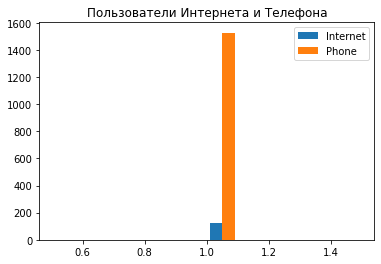

In [48]:
plt.hist([low_charges[low_charges.internet == 1].internet, low_charges[low_charges.phone == 1].phone], label=['Internet', 'Phone']);
plt.legend();
plt.title('Пользователи Интернета и Телефона');
plt.show();

Вполне логично, что данный срез пользователей - пользователи телефонных услуг

**Подгатовка к обучению**

Константы

In [49]:
RANDOM = 27112023
KFOLD = StratifiedKFold(n_splits=10, random_state=RANDOM, shuffle=True)

PHIK

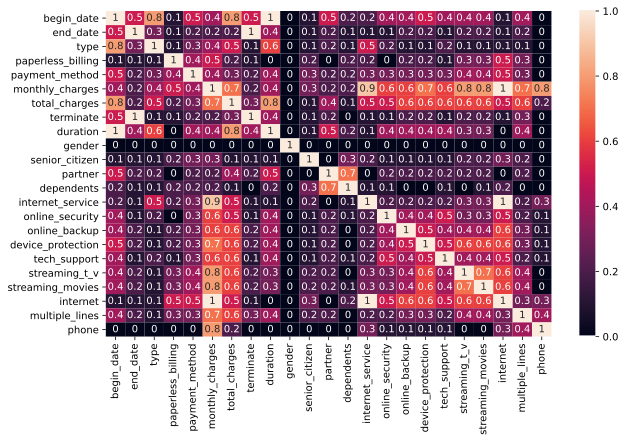

In [50]:
from matplotlib import rcParams, rcParamsDefault
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
correlation_matrix = data.phik_matrix(interval_cols = ['monthly_charges', 'total_charges', 'duration'])
#display(correlation_matrix)
sns.heatmap(correlation_matrix.copy().round(1), annot=True);
plt.show()

Разбиваем датасет на срез без дат, и срез без доп услуг

In [51]:
data_one = data.drop(['begin_date', 'end_date'], axis=1)
#data_two = data.drop(['begin_date', 'end_date', 'internet_service','online_security','online_backup','device_protection','tech_support','streaming_t_v','streaming_movies', 'multiple_lines'], axis=1)


 
Удалим ненужные для обучения столбцы begin_date и end_date, тк такие факторы увеличат метрики, но бизнес-эффективность модели будет падать


Кодируем признаки

In [54]:
X = data_one.drop(['terminate'], axis = 1 )

y = data_one['terminate']

Разбиваем данные на выборки

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM)

In [58]:
data_one_encoded = pd.get_dummies(X_train.select_dtypes(include=['object']), drop_first=True)
data_one_encoded_columns = data_one_encoded.columns
X_train = X_train.drop(X_train.select_dtypes(include=['object']), axis=1)
X_train = X_train.join(data_one_encoded)

In [59]:
data_two_encoded = pd.get_dummies(X_test.select_dtypes(include=['object']), drop_first=True)
data_two_encoded = data_two_encoded.reindex(columns=data_one_encoded_columns, fill_value=0)
X_test = X_test.drop(X_test.select_dtypes(include=['object']), axis=1)
X_test = X_test.join(data_two_encoded)

In [73]:
# код ментора для проверки
print((X_train.columns == X_test.columns).all()) #'столбцы в выборках не совпадают'

True


Производим масштабирование признаков

In [61]:
numeric = ['monthly_charges', 'total_charges', 'duration']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

**Обучение моделей**

Функция для формирования свободной таблицы с результатами

In [62]:
results = pd.DataFrame(columns=['Модель', 'AUC ROC'])

def add_model_result(model_name, auc_roc_score):
    global results
    results = results.append({'Модель': model_name, 'AUC ROC': auc_roc_score}, ignore_index=True)
    results = results.sort_values(by='AUC ROC', ascending=False)
    return results

RANDOM FOREST

In [63]:
model_forest = RandomForestClassifier(random_state=RANDOM)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None]
}

grid_search = GridSearchCV(estimator=model_forest, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_forest = grid_search.best_estimator_

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат на кросс-валидации (ROC AUC):", grid_search.best_score_)

add_model_result("RandomForestClassifier", grid_search.best_score_)

Лучшие параметры: {'max_depth': 10, 'n_estimators': 300}
Лучший результат на кросс-валидации (ROC AUC): 0.8197440087888447


,Модель,AUC ROC
0,RandomForestClassifier,0.819744


LOGISTIC REGRESSION

In [64]:
model_log = LogisticRegression(random_state=RANDOM, solver='liblinear')

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(estimator=model_log, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_logistic = grid_search.best_estimator_

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат на кросс-валидации (ROC AUC):", grid_search.best_score_)

add_model_result("LogisticRegression", grid_search.best_score_)

Лучшие параметры: {'C': 10}
Лучший результат на кросс-валидации (ROC AUC): 0.765169842378292


,Модель,AUC ROC
0,RandomForestClassifier,0.819744
1,LogisticRegression,0.765170


CAT BOOST

In [65]:
model_cat = CatBoostClassifier(random_state=RANDOM)

param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8]
}

grid_search = GridSearchCV(estimator=model_cat, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_cat = grid_search.best_estimator_

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат на кросс-валидации (ROC AUC):", grid_search.best_score_)

add_model_result("CatBoostClassifier", grid_search.best_score_)

Learning rate set to 0.157457
0:	learn: 0.5916970	total: 48.5ms	remaining: 4.8s
1:	learn: 0.5100371	total: 50.5ms	remaining: 2.48s
2:	learn: 0.4630823	total: 52.2ms	remaining: 1.69s
3:	learn: 0.4245694	total: 53.9ms	remaining: 1.29s
4:	learn: 0.3993708	total: 55.6ms	remaining: 1.06s
5:	learn: 0.3839133	total: 57.1ms	remaining: 895ms
6:	learn: 0.3735208	total: 59ms	remaining: 784ms
7:	learn: 0.3657944	total: 60.9ms	remaining: 700ms
8:	learn: 0.3574336	total: 62.3ms	remaining: 630ms
9:	learn: 0.3497435	total: 63.6ms	remaining: 573ms
10:	learn: 0.3466890	total: 65ms	remaining: 526ms
11:	learn: 0.3425657	total: 66.2ms	remaining: 486ms
12:	learn: 0.3385505	total: 67.6ms	remaining: 452ms
13:	learn: 0.3352768	total: 69.6ms	remaining: 428ms
14:	learn: 0.3327438	total: 71.5ms	remaining: 405ms
15:	learn: 0.3307426	total: 73.4ms	remaining: 385ms
16:	learn: 0.3278477	total: 75.4ms	remaining: 368ms
17:	learn: 0.3258667	total: 77.2ms	remaining: 352ms
18:	learn: 0.3241710	total: 79ms	remaining: 337ms

,Модель,AUC ROC
2,CatBoostClassifier,0.872198
0,RandomForestClassifier,0.819744
1,LogisticRegression,0.765170


Смотрим результаты

In [66]:
results

,Модель,AUC ROC
2,CatBoostClassifier,0.872198
0,RandomForestClassifier,0.819744
1,LogisticRegression,0.765170


Лучший результат на кросс-валидации показала CatBoostClassifier, произведем запуск на тест выборке

In [67]:
pred_proba_test_cat = best_cat.predict_proba(X_test)[:, 1]
auc_roc_test_cat = roc_auc_score(y_test, pred_proba_test_cat)
print(auc_roc_test_cat)

0.891052485933032


Получаем AUC ROC = 0.89

Вычислим важность факторов

In [68]:

importance = best_cat.feature_importances_
feature_names = X_test.columns


importance_table = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_table = importance_table.sort_values(by='Importance', ascending=False)


print(importance_table)


                                   Feature  Importance
2                                 duration   40.884018
1                            total_charges    9.399201
0                          monthly_charges    9.044399
5                            type_Two year    6.129056
11                             partner_Yes    4.550448
4                            type_One year    3.537575
22                      multiple_lines_Yes    3.397328
16                       online_backup_Yes    2.942829
9              payment_method_Mailed check    2.683898
12                          dependents_Yes    2.086347
6                    paperless_billing_Yes    2.073866
20                    streaming_movies_Yes    1.500830
17                   device_protection_Yes    1.466469
23                                phone_No    1.464776
19                       streaming_t_v_Yes    1.324381
3                           senior_citizen    1.323081
15                     online_security_Yes    1.082661
8         

Визуализируем

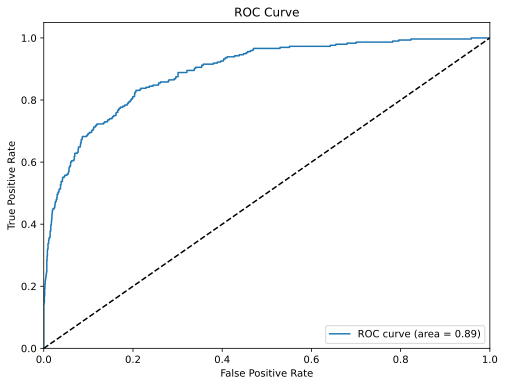

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc_test_cat)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Считаем метрику accuarcy

In [70]:
pred_test_cat = best_cat.predict(X_test)
accuracy = accuracy_score(y_test, pred_test_cat)
print("Accuracy score:", accuracy)

Accuracy score: 0.8824531516183987


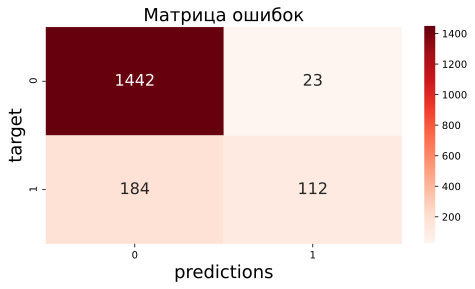

In [71]:
cm_cbc = confusion_matrix(y_test, pred_test_cat)
cm_cbc_data = pd.DataFrame(cm_cbc,
                           index=['0', '1'],
                           columns=['0', '1'])

plt.figure(figsize=(8, 4))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', cmap="Reds", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);

- В 82 % от общего кол-ва тестовых данных - правильно опеределяем класс 0

- 7 % - правильное предсказание класса 1

- 1.5% мы неправильно угадываем класс 0 (когда клиент не хочет уходить, а мы говорим что он уйдет)

- 10% - мы не правильно угадываем класс 1 (когда клиент хочет уйти, а мы говорим что он не уйдет)

**ОБЩИЙ ВЫВОД:**
- Предварительный просмотр и  анализ данных 4 исходных датасетов
- Предобработка, включая добавление дополнительных признаков, объединение всех датасетов в один, заполнение образовавшихся пропусков.
- Исследовательский анализ данных, в ходе которого были изучены особенности обьединенного датасета
- Подготовка к обучению: разделение данных на несколько частей (полный набор и набор без дополнительных услуг), кодирование признаков методом прямого кодирования OHE, масштабирование признаков методом стандартизации, и визуализацию влияния признаков.
- Обучение моделей: были обучены три модели - RandomForestClassifier, LogisticRegression, CatBoostClassifier с применением поиска лучших гиперпараметров GridSearch
- Получение результата на тестовой выборке и визуализация: в результате обучения лучшую производительность продемонстрировала модель CatBoostClassifier, на которой была достигнута метрика  тест ROC_AUC = 0.89